In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

In [7]:
# Cyclical stocks
cyclical_stocks = {
    "AMZN": "Amazon", "NKE": "Nike", "SBUX": "Starbucks", "HD": "Home Depot", "GM": "General Motors",
    "JPM": "JPMorgan Chase", "BAC": "Bank of America", "GS": "Goldman Sachs", "WFC": "Wells Fargo", "AXP": "American Express",
    "CAT": "Caterpillar", "BA": "Boeing", "UNP": "Union Pacific", "HON": "Honeywell", "MMM": "3M",
    "DOW": "Dow Inc.", "FCX": "Freeport-McMoRan", "NEM": "Newmont", "LYB": "LyondellBasell", "IP": "International Paper"
}

# Defensive stocks
defensive_stocks = {
    "PG": "Procter & Gamble", "KO": "Coca-Cola", "PEP": "PepsiCo", "CL": "Colgate-Palmolive", "WMT": "Walmart",
    "NEE": "NextEra Energy", "DUK": "Duke Energy", "SO": "Southern Company", "D": "Dominion Energy", "AEP": "American Electric Power",
    "JNJ": "Johnson & Johnson", "PFE": "Pfizer", "MRK": "Merck", "UNH": "UnitedHealth Group", "ABT": "Abbott Laboratories",
    "O": "Realty Income", "SPG": "Simon Property Group", "PSA": "Public Storage", "WELL": "Welltower", "DLR": "Digital Realty"
}

# Cyclical stocks sector map
cyclical_sector_map = {
    "AMZN": "Consumer Discretionary", "NKE": "Consumer Discretionary", "SBUX": "Consumer Discretionary", 
    "HD": "Consumer Discretionary", "GM": "Consumer Discretionary",
    "JPM": "Financials", "BAC": "Financials", "GS": "Financials", "WFC": "Financials", "AXP": "Financials",
    "CAT": "Industrials", "BA": "Industrials", "UNP": "Industrials", "HON": "Industrials", "MMM": "Industrials",
    "DOW": "Materials", "FCX": "Materials", "NEM": "Materials", "LYB": "Materials", "IP": "Materials"
}

# Defensive stocks sector map
defensive_sector_map = {
    "PG": "Consumer Staples", "KO": "Consumer Staples", "PEP": "Consumer Staples", 
    "CL": "Consumer Staples", "WMT": "Consumer Staples",
    "NEE": "Utilities", "DUK": "Utilities", "SO": "Utilities", "D": "Utilities", "AEP": "Utilities",
    "JNJ": "Healthcare", "PFE": "Healthcare", "MRK": "Healthcare", "UNH": "Healthcare", "ABT": "Healthcare",
    "O": "Real Estate", "SPG": "Real Estate", "PSA": "Real Estate", "WELL": "Real Estate", "DLR": "Real Estate"
}


In [8]:
import yfinance as yf
import pandas as pd

# Function to download data (much faster than manually downloading)
def download_stock_data(stock_dict, interval='1wk'):
    df = pd.DataFrame()
    for ticker in stock_dict.keys():
        stock_data = yf.download(ticker, period="5y", interval=interval)  # 5 years of weekly data
        if 'Close' in stock_data.columns:
            df[ticker] = stock_data['Close']
    return df

cyclical_df = download_stock_data(cyclical_stocks)
defensive_df = download_stock_data(defensive_stocks)

cyclical_df.index = pd.to_datetime(cyclical_df.index)
defensive_df.index = pd.to_datetime(defensive_df.index)

cyclical_dates = cyclical_df.index
defensive_dates = defensive_df.index

cyclical_df.index = cyclical_dates
defensive_df.index = defensive_dates


# Display the first few rows
print("Cyclical Portfolio Data:")
display(cyclical_df.head())

print("\nDefensive Portfolio Data:")
display(defensive_df.head())

print("\nDimensions of Cyclical Portfolio Data:", cyclical_df.shape)
print("\nDimensions of Defensive Portfolio Data:", defensive_df.shape)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Cyclical Portfolio Data:


,AMZN,NKE,SBUX,HD,GM,JPM,BAC,GS,WFC,AXP,CAT,BA,UNP,HON,MMM,DOW,FCX,NEM,LYB,IP
Date,,,,,,,,,,,,,,,,,,,,
2020-04-06,102.138000,81.752739,66.344994,178.715179,23.394623,89.417953,21.954859,163.222992,29.229303,88.815506,112.406143,151.839996,133.356796,129.341995,101.365150,28.081259,7.752494,48.750965,43.393478,25.830065
2020-04-13,118.750000,84.691658,69.236595,185.711975,21.858318,82.822113,20.559498,162.540894,24.985769,81.856026,104.557564,154.000000,134.396927,124.733932,100.459740,25.669464,7.894481,50.384216,38.430431,24.076317
2020-04-20,120.511002,83.241020,67.871597,188.159515,21.342976,78.932495,19.588037,156.791870,23.700384,77.903244,103.467026,128.979996,139.956070,122.208908,100.830124,25.439035,8.027002,53.684753,36.854630,23.532047
2020-04-27,114.302002,80.575279,66.264160,193.826157,20.322010,81.142693,20.382862,156.880463,24.290255,82.727112,100.599998,133.369995,140.449219,123.768997,101.927589,26.061188,8.008071,51.881367,40.617409,25.633520
2020-05-04,118.980499,85.209747,69.928055,207.890625,23.268221,80.664101,20.815601,164.223969,22.388584,83.832405,101.715973,133.440002,141.901779,123.462410,101.865845,26.368422,8.718006,54.909691,41.567310,25.966131



Defensive Portfolio Data:


,PG,KO,PEP,CL,WMT,NEE,DUK,SO,D,AEP,JNJ,PFE,MRK,UNH,ABT,O,SPG,PSA,WELL,DLR
Date,,,,,,,,,,,,,,,,,,,,
2020-04-06,101.331184,42.022686,115.497780,62.194572,37.730091,54.355900,73.737175,49.480072,65.752129,71.842735,122.739555,26.937494,67.513351,245.429428,78.777458,42.972553,51.376572,168.767319,48.352875,124.375359
2020-04-13,110.195221,41.216534,118.885864,65.317177,40.926937,54.573074,73.565720,47.134430,65.687660,71.901009,132.116882,28.094454,68.307236,269.988129,87.905907,39.704876,42.295040,158.969284,41.945686,125.138626
2020-04-20,104.972244,38.961033,116.128708,63.906166,40.096745,53.119324,69.964966,47.347668,62.794533,69.279015,134.585083,28.452200,66.645782,270.666473,86.483139,37.847389,38.805634,151.485260,37.640060,125.834747
2020-04-27,103.928596,39.106823,112.481346,61.337379,38.077034,50.315990,67.474709,44.624748,60.932949,67.747437,128.875229,28.650106,63.568447,264.366486,82.612274,39.265144,47.630917,149.163162,40.433590,122.387589
2020-05-04,103.154579,39.544209,116.016327,62.089218,38.083241,50.909904,66.772499,45.444897,63.181362,66.473885,129.231506,28.330418,62.529045,266.680237,86.152145,41.768772,43.726986,154.001480,38.058662,121.666275



Dimensions of Cyclical Portfolio Data: (262, 20)

Dimensions of Defensive Portfolio Data: (262, 20)


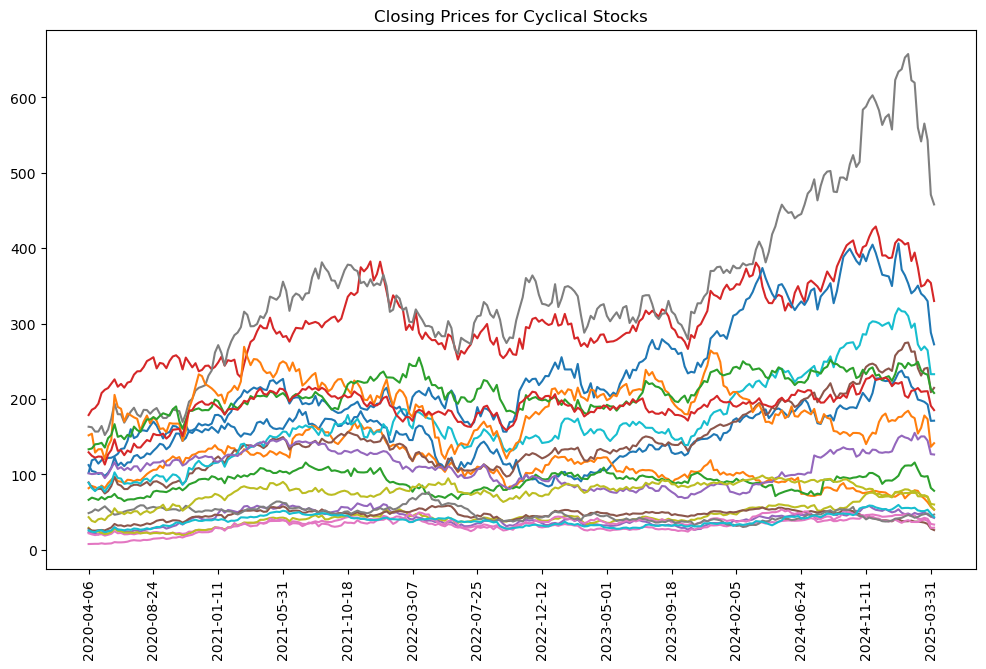

In [9]:
# Plot the cyclical stocks
plt.figure(figsize=(12, 7))
plt.plot(cyclical_df)
plt.xlabel('')
_ = plt.xticks(cyclical_dates[np.arange(0, len(cyclical_dates), 20)], rotation=90)
plt.title('Closing Prices for Cyclical Stocks')
plt.show()

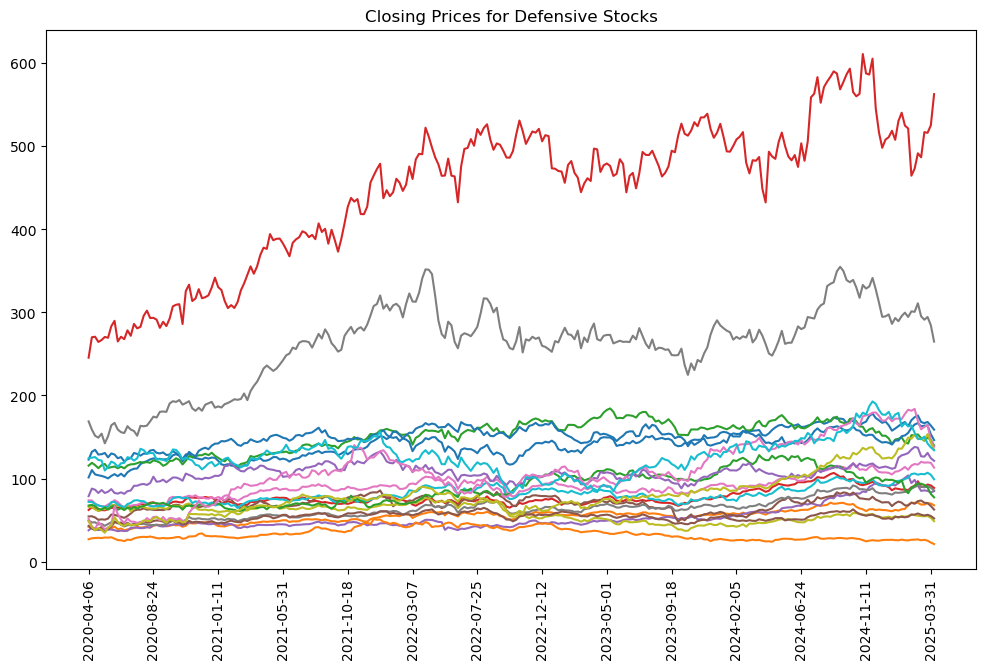

In [10]:
# Plot the cyclical stocks
plt.figure(figsize=(12, 7))
plt.plot(defensive_df)
plt.xlabel('')
_ = plt.xticks(defensive_dates[np.arange(0, len(cyclical_dates), 20)], rotation=90)
plt.title('Closing Prices for Defensive Stocks') 
plt.show()

In [11]:
# Transform the data to log-returns for cylical stocks

df_cylical_log_returns = np.log1p(cyclical_df.pct_change()).iloc[1:]
df_cylical_log_returns

,AMZN,NKE,SBUX,HD,GM,JPM,BAC,GS,WFC,AXP,CAT,BA,UNP,HON,MMM,DOW,FCX,NEM,LYB,IP
Date,,,,,,,,,,,,,,,,,,,,
2020-04-13,0.150696,0.035318,0.042661,0.038404,-0.067925,-0.076626,-0.065665,-0.004188,-0.156865,-0.081599,-0.072381,0.014125,0.007769,-0.036277,-0.008972,-0.089800,0.018149,0.032953,-0.121460,-0.070310
2020-04-20,0.014721,-0.017277,-0.019912,0.013093,-0.023859,-0.048102,-0.048404,-0.036010,-0.052815,-0.049494,-0.010485,-0.177295,0.040531,-0.020451,0.003680,-0.009017,0.016647,0.063451,-0.041868,-0.022865
2020-04-27,-0.052897,-0.032548,-0.023968,0.029672,-0.049018,0.027616,0.039775,0.000565,0.024584,0.060080,-0.028101,0.033470,0.003517,0.012685,0.010825,0.024162,-0.002361,-0.034169,0.097216,0.085538
2020-05-04,0.040116,0.055924,0.053818,0.070050,0.135384,-0.005916,0.021008,0.045747,-0.081524,0.013272,0.011032,0.000525,0.010289,-0.002480,-0.000606,0.011720,0.084941,0.056730,0.023117,0.012892
2020-05-11,0.012599,-0.039115,-0.043180,0.020686,-0.055856,-0.076184,-0.094716,-0.075723,-0.064789,-0.084840,-0.038090,-0.106160,-0.045372,-0.087736,-0.068411,-0.022685,-0.082579,0.050596,-0.051806,-0.101003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,-0.006546,-0.087263,-0.081868,-0.070046,0.021339,-0.041462,-0.006105,-0.033170,-0.002819,-0.028136,-0.030904,0.048302,-0.048403,-0.023822,0.027706,-0.012900,0.050413,0.058534,-0.044188,-0.017164
2025-03-17,-0.008829,-0.053308,-0.010657,0.005871,0.029756,0.038776,0.037912,0.042897,0.023297,0.018205,-0.011430,0.095979,-0.015486,0.003098,-0.000333,-0.021877,0.035402,0.023933,-0.018252,-0.000389
2025-03-24,-0.017947,-0.070898,0.006776,0.019738,-0.064699,0.005036,-0.029147,-0.039743,-0.025558,-0.018769,-0.018303,-0.027319,-0.007424,0.001046,-0.037403,-0.051337,-0.046532,0.015088,-0.024476,0.034803


In [12]:
# Transform the data to log-returns for defensive stocks

df_defensive_log_returns = np.log1p(defensive_df.pct_change()).iloc[1:]
df_defensive_log_returns

,PG,KO,PEP,CL,WMT,NEE,DUK,SO,D,AEP,JNJ,PFE,MRK,UNH,ABT,O,SPG,PSA,WELL,DLR
Date,,,,,,,,,,,,,,,,,,,,
2020-04-13,0.083859,-0.019370,0.028913,0.048987,0.081331,0.003987,-0.002328,-0.048566,-0.000981,0.000811,0.073622,0.042053,0.011690,0.095369,0.109640,-0.079088,-0.194512,-0.059810,-0.142150,0.006118
2020-04-20,-0.048558,-0.056277,-0.023465,-0.021839,-0.020493,-0.027000,-0.050185,0.004514,-0.045043,-0.037148,0.018510,0.012653,-0.024624,0.002509,-0.016318,-0.047912,-0.086104,-0.048223,-0.108307,0.005547
2020-04-27,-0.009992,0.003735,-0.031912,-0.041026,-0.051684,-0.054218,-0.036242,-0.059229,-0.030094,-0.022355,-0.043352,0.006932,-0.047275,-0.023551,-0.045791,0.036775,0.204917,-0.015448,0.071592,-0.027777
2020-05-04,-0.007475,0.011122,0.030944,0.012183,0.000163,0.011735,-0.010462,0.018212,0.036235,-0.018977,0.002761,-0.011221,-0.016486,0.008714,0.041957,0.061812,-0.085517,0.031921,-0.060532,-0.005911
2020-05-11,-0.011624,-0.063802,0.012733,-0.006073,0.028498,-0.008217,-0.007240,-0.053185,-0.002299,-0.009148,0.011634,0.024321,0.043290,0.013703,-0.041511,-0.092962,-0.122707,-0.078498,-0.091613,-0.103707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,-0.046414,-0.032295,-0.029812,-0.074219,-0.071980,0.009838,0.028542,-0.011223,-0.009827,0.008945,-0.023552,-0.038518,-0.000846,-0.009836,-0.079101,-0.026377,-0.059540,-0.051800,0.002641,-0.004030
2025-03-17,-0.007650,0.000242,-0.021358,0.005330,0.007354,-0.036977,-0.008528,-0.011350,-0.002380,-0.004272,0.005024,0.021539,-0.015559,0.060371,-0.002924,-0.015824,0.017855,-0.013790,-0.008969,0.020504
2025-03-24,0.008007,0.024455,0.025924,0.027525,-0.006958,-0.006085,0.002600,0.019614,0.008034,0.017447,0.000489,-0.041568,-0.033962,-0.001568,0.034846,0.014412,0.013359,0.011033,0.046017,-0.056634


Text(0.5, 1.0, 'Log-Returns for Cyclical Stocks')

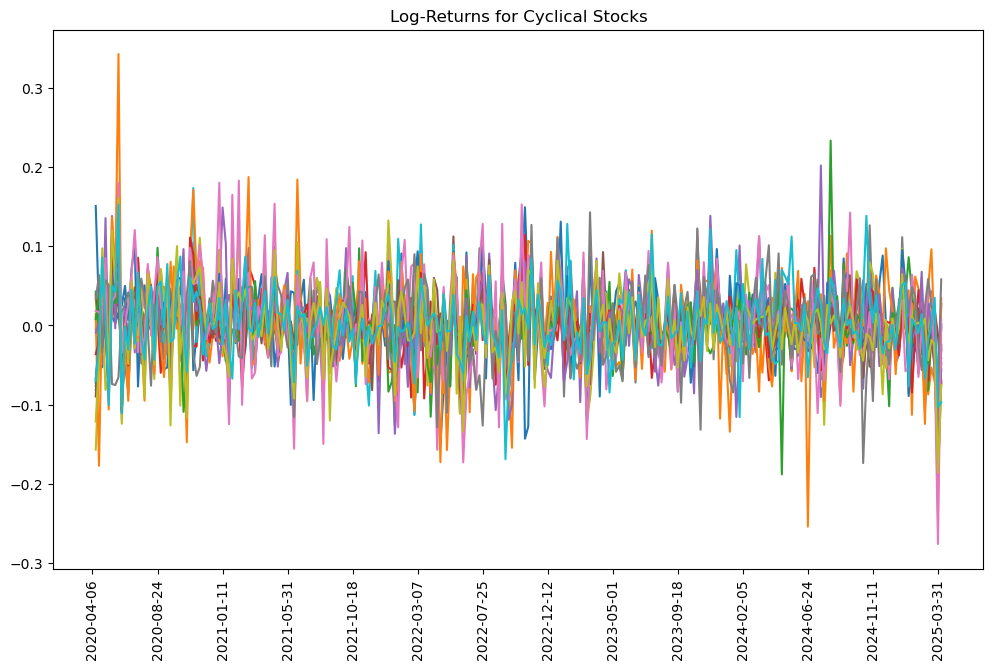

In [13]:
# Plot the transformed cyclical stocks

plt.figure(figsize=(12, 7))
plt.plot(df_cylical_log_returns)
plt.xlabel('')
_ = plt.xticks(cyclical_dates[np.arange(0, len(cyclical_dates), 20)], rotation=90)
plt.title('Log-Returns for Cyclical Stocks')

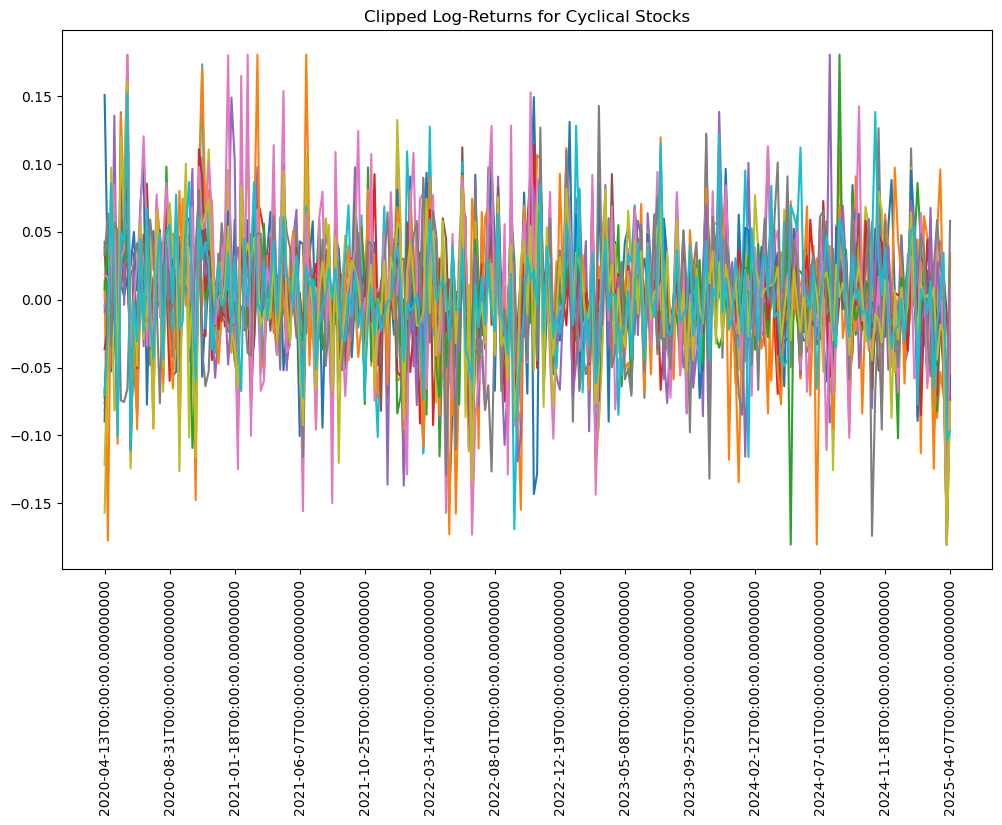

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate log-returns and convert to numpy array (skip the first row to avoid NaN)
cylical_log_returns = np.array(np.log1p(cyclical_df.pct_change()).iloc[1:])

# Define the clipping threshold based on the numpy array
std_dev = 4 * np.std(cylical_log_returns)

# Clip the log returns array
clipped_cylical_log_returns = np.clip(cylical_log_returns, -std_dev, std_dev)

# Plot the clipped log returns
plt.figure(figsize=(12, 7))
plt.plot(clipped_cylical_log_returns)
plt.xlabel('')
plt.xticks(ticks=np.arange(0, len(cyclical_dates[1:]), 20), labels=np.array(cyclical_dates[1:])[np.arange(0, len(cyclical_dates[1:]), 20)], rotation=90)
plt.title('Clipped Log-Returns for Cyclical Stocks')
plt.show()

Text(0.5, 1.0, 'Log-Returns for Defensive Stocks')

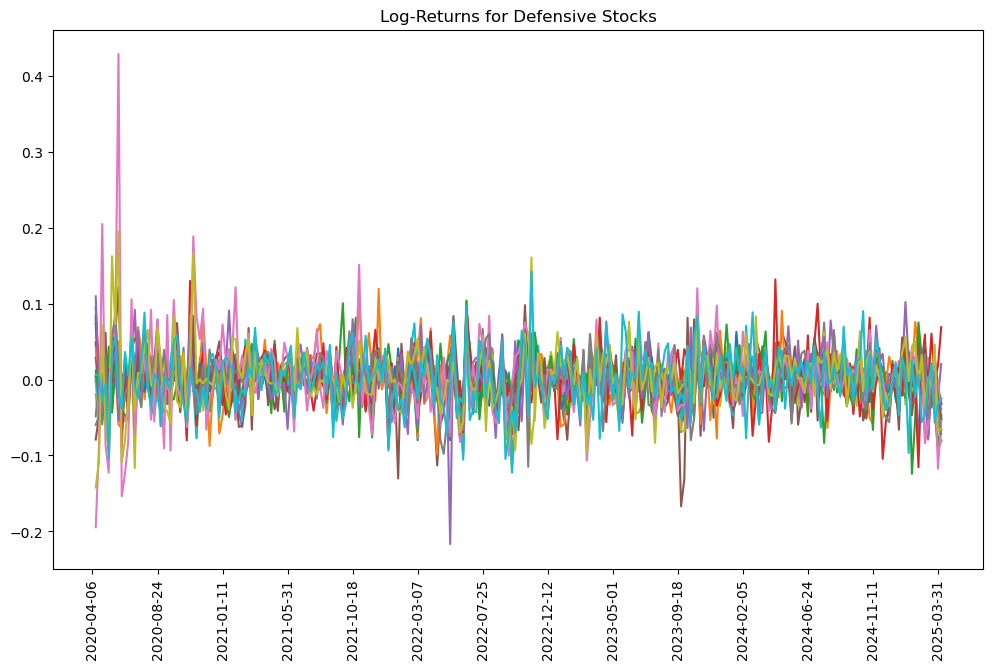

In [15]:
# Plot the transformed defensive stocks

plt.figure(figsize=(12, 7))
plt.plot(df_defensive_log_returns)
plt.xlabel('')
_ = plt.xticks(defensive_dates[np.arange(0, len(defensive_dates), 20)], rotation=90)
plt.title('Log-Returns for Defensive Stocks') 

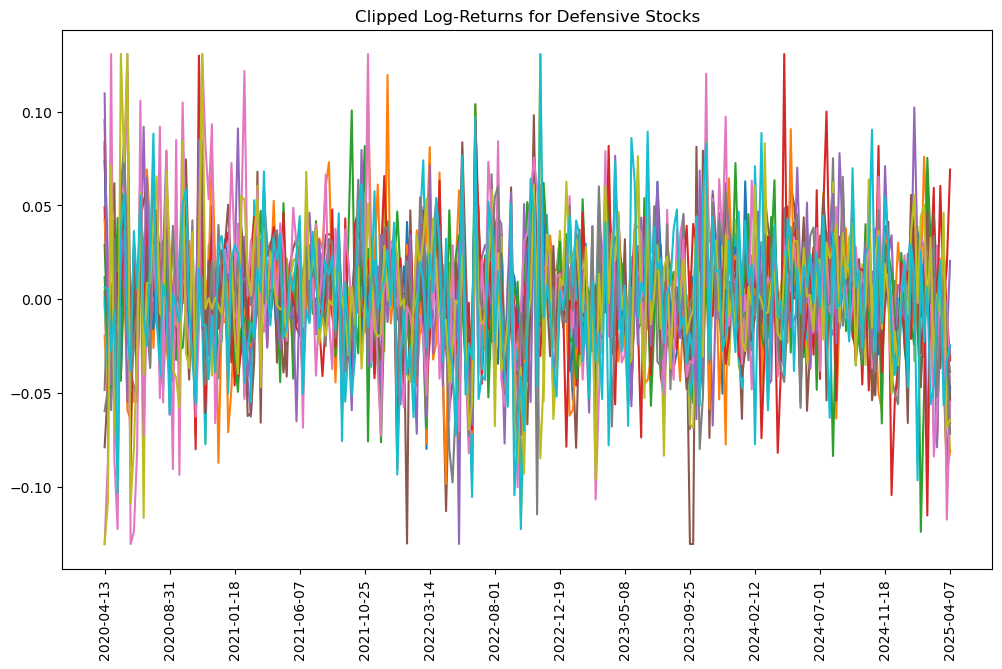

In [16]:
# Clip the log-returns for defensive stocks

defensive_log_returns = np.array(np.log1p(defensive_df.pct_change()).iloc[1:])

std_dev_defensive = 4 * np.std(defensive_log_returns)

clipped_defensive_log_returns = np.clip(defensive_log_returns, -std_dev_defensive, std_dev_defensive)

plt.figure(figsize=(12, 7))
plt.plot(clipped_defensive_log_returns)
plt.xlabel('')
plt.xticks(ticks=np.arange(0, len(defensive_dates[1:]), 20), 
           labels=[date.strftime('%Y-%m-%d') for date in defensive_dates[1:]][::20], 
           rotation=90)
plt.title('Clipped Log-Returns for Defensive Stocks') 
plt.show()

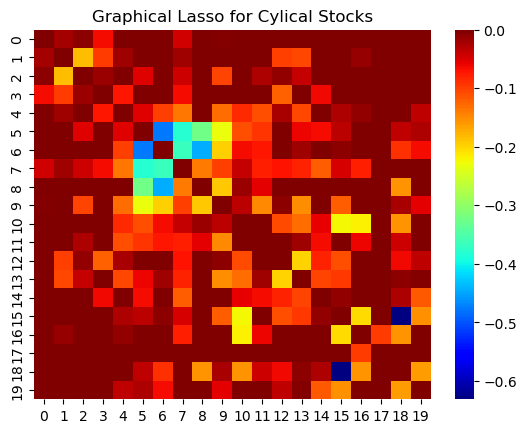

In [17]:
# Run the Graphical Lasso for Cylical Stocks

from sklearn.covariance import GraphicalLasso
import seaborn as sns
import networkx as nx

X1 = np.array(clipped_cylical_log_returns)
p1 = X1.shape[1]
X1 = (X1 - np.mean(X1, axis=0)) / np.std(X1, axis=0)
glasso1 = GraphicalLasso(alpha=.3).fit(X1)
Omeghat1 = np.around(glasso1.precision_, decimals=5)

for j in np.arange(p1): 
    Omeghat1[j,j] = 0
sns.heatmap(Omeghat1, cmap='jet')
plt.title('Graphical Lasso for Cylical Stocks')
plt.show()

In [ ]:
# Run the Graphical Lasso for Cylical Stocks
np.random.seed(42)

sector_colors1 = {
    "Consumer Discretionary": "skyblue",
    "Financials": "lightgreen",
    "Industrials": "salmon",
    "Materials": "orange"
}

# Use stock symbols as node labels
cylical_stocks_names = list(cyclical_stocks.keys())  
precdf1 = pd.DataFrame(Omeghat1, columns=cylical_stocks_names, index=cylical_stocks_names)

# Generate the links for the edges
links1 = precdf1.stack().reset_index()
links1.columns = ['var1', 'var2', 'value']
links1 = links1.loc[(abs(links1['value']) > 0.01) & (links1['var1'] != links1['var2'])]

# Build the graph using stock symbols
G1 = nx.from_pandas_edgelist(links1, 'var1', 'var2', create_using=nx.Graph())
pos1 = nx.spring_layout(G1, k=1.7/np.sqrt(len(G1.nodes())), iterations=20)

# Set colors for each node based on sector
node_colors1 = [sector_colors1[cyclical_sector_map[node]] for node in G1.nodes]

# Visualize the Network for Cyclical Stocks with Colored Nodes
plt.figure(figsize=(10, 10))
nx.draw(G1, pos=pos1, node_color=node_colors1, with_labels=False, node_size=500, edge_color="gray")
nx.draw_networkx_labels(G1, pos=pos1, font_size=10)
plt.title('FINAL Network for Cyclical Stocks (alpha=0.3)')
for sector, color in sector_colors1.items():
    plt.scatter([], [], color=color, label=sector)
plt.legend(loc="upper right", title="Sector Colors")
plt.show()


NameError: name 'cylical_stocks_names' is not defined

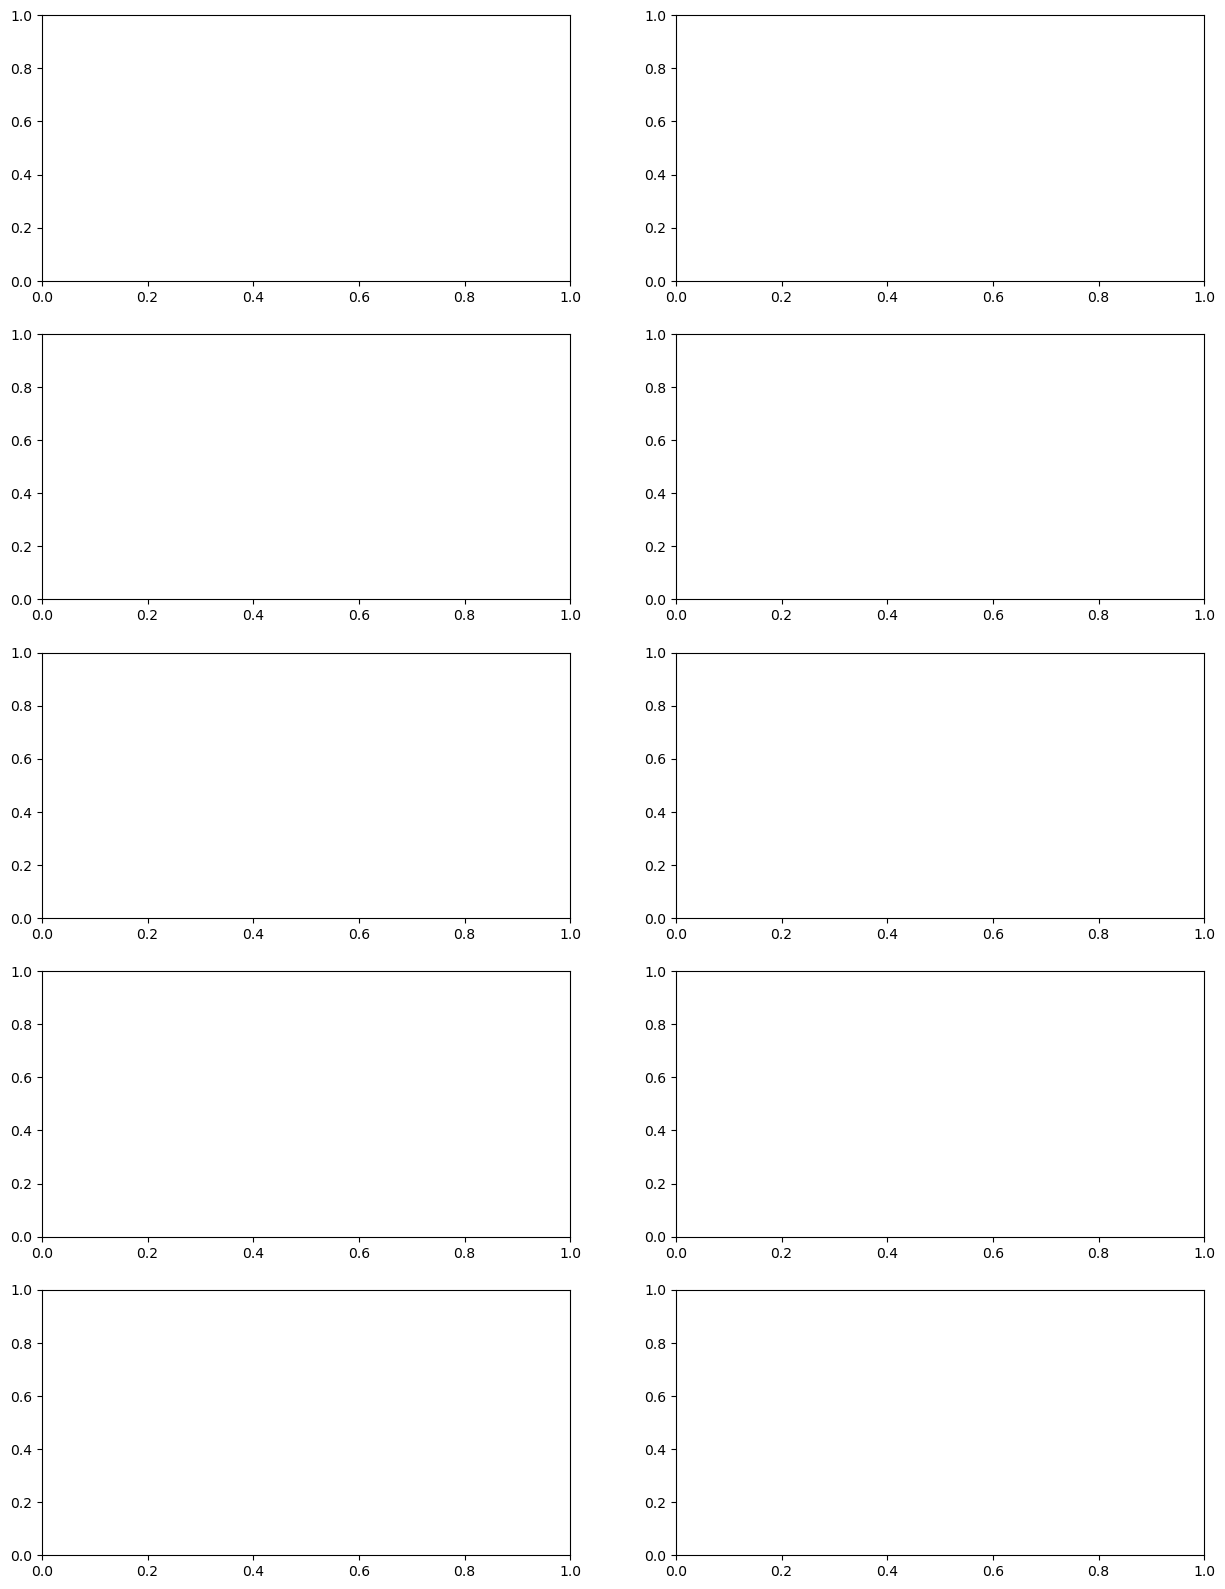

In [18]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
alpha_values = np.linspace(0, 0.9, 10)

for i, alpha in enumerate(alpha_values):
    glasso = GraphicalLasso(alpha=alpha).fit(X1)
    Omeghat = np.around(glasso.precision_, decimals=5)
    for j in np.arange(p1): 
        Omeghat[j, j] = 0
    precdf = pd.DataFrame(Omeghat, columns=cylical_stocks_names, index=cylical_stocks_names)
    links = precdf.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links = links.loc[(abs(links['value']) > 0.01) & (links['var1'] != links['var2'])]
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', create_using=nx.Graph())
    pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20, seed=42)
    node_colors = [sector_colors1[cyclical_sector_map[node]] for node in G.nodes]
    ax = axes[i // 2, i % 2]
    nx.draw(G, pos=pos, node_color=node_colors, with_labels=False, node_size=500, edge_color="gray", ax=ax)
    nx.draw_networkx_labels(G, pos=pos, font_size=8, ax=ax)
    ax.set_title(f'Network for Cyclical Stocks (alpha={alpha:.1f})')

plt.tight_layout()
plt.show()


In [ ]:
# Run the Graphical Lasso for Defensive Stocks 

X2 = np.array(clipped_defensive_log_returns)
p2 = X2.shape[1]
X2 = (X2 - np.mean(X1, axis=0)) / np.std(X2, axis=0)
glasso2 = GraphicalLasso(alpha=.3).fit(X2)
Omeghat2 = np.around(glasso2.precision_, decimals=5)

for j in np.arange(p2): 
    Omeghat2[j,j] = 0
sns.heatmap(Omeghat2, cmap='jet')
plt.title('Graphical Lasso for Defensive Stocks')
plt.show()

In [ ]:
# Run the Graphical Lasso for Defensive Stocks
np.random.seed(42)

sector_colors2 = {
    "Consumer Staples": "mediumseagreen",
    "Utilities": "slateblue",
    "Healthcare": "lightcoral",
    "Real Estate": "goldenrod"
}


# Use stock symbols as node labels
defensive_stocks_names = list(defensive_stocks.keys())  
precdf2 = pd.DataFrame(Omeghat2, columns=defensive_stocks_names, index=defensive_stocks_names)

# Generate the links for the edges
links2 = precdf2.stack().reset_index()
links2.columns = ['var1', 'var2', 'value']
links2 = links2.loc[(abs(links2['value']) > 0.01) & (links2['var1'] != links2['var2'])]

# Build the graph using stock symbols
G2 = nx.from_pandas_edgelist(links2, 'var1', 'var2', create_using=nx.Graph())
pos2 = nx.spring_layout(G2, k=1.7/np.sqrt(len(G2.nodes())), iterations=20)

# Set colors for each node based on sector
node_colors2 = [sector_colors2[defensive_sector_map[node]] for node in G2.nodes]

# Visualize the Network for Cyclical Stocks with Colored Nodes
plt.figure(figsize=(10, 10))
nx.draw(G2, pos=pos2, node_color=node_colors2, with_labels=False, node_size=500, edge_color="gray")
nx.draw_networkx_labels(G2, pos=pos2, font_size=10)
plt.title('FINAL Network for Defensive Stocks (alpha=0.3)')
for sector, color in sector_colors2.items():
    plt.scatter([], [], color=color, label=sector)
plt.legend(loc="upper left", title="Sector Colors")
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
alpha_values = np.linspace(0, 0.9, 10)

for i, alpha in enumerate(alpha_values):
    glasso = GraphicalLasso(alpha=alpha).fit(X2)
    Omeghat = np.around(glasso.precision_, decimals=5)
    for j in np.arange(p2): 
        Omeghat[j, j] = 0
    precdf = pd.DataFrame(Omeghat, columns=defensive_stocks_names , index=defensive_stocks_names)
    links = precdf.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links = links.loc[(abs(links['value']) > 0.01) & (links['var1'] != links['var2'])]
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', create_using=nx.Graph())
    pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20, seed=42)
    node_colors = [sector_colors2[defensive_sector_map[node]] for node in G.nodes]
    ax = axes[i // 2, i % 2]
    nx.draw(G, pos=pos, node_color=node_colors, with_labels=False, node_size=500, edge_color="gray", ax=ax)
    nx.draw_networkx_labels(G, pos=pos, font_size=8, ax=ax)
    ax.set_title(f'Network for Defensive Stocks (alpha={alpha:.1f})')

plt.tight_layout()
plt.show()


### Report

I decided to construct two portfolios, each containing 20 stocks, that represent cylical and defensive sectors of the market. The first portfolio contains four sectors: Consumer Discretionary, Financials, Industrials, and Materials, all of which are known as "cylical" because they are highly influenced by current economy, and tend to rise in value during economic prosperity and fall during economic downturn. The second portfolio also contains four sectors: Consumer Staples, Utilities, Healthcare, and Real Estate, which are known as "defensive" because of their low volatility and consistent demand despite the economy. I chose five years of weekly data for each portfolio (i.e. starting five years before the week of this assignment) to get a sense of how cylical sectors are influencing each other in the present-day, and similarly with defensive sectors. 

I used a combination of strategies to choose the optimal regularization level in the glasso for each portfolio. In particular, I used cross-validation by plotting 10 graphs for each portfolio corresponding to regularization strengths lambda = 0.0 ... lambda = 0.9. I ended up selecting lambda = 0.3 for both portfolios. This was because the graphs associated with lambda = 0.3 featured meaningful connections while not becoming too parse (in particular, all of the nodes had at least one connection, which allows us to visualize various relationships between all of the stocks in the portfolios instead of a restricted subset). Most importantly, lambda=0.3 led to well-defined local clusters which provide a meaningful interpretation for analyzing my data. Given this regularization strength, the structure of the graphs makes a good deal of sense. Both of the graphs were quite sensitive to the choice of regularization level; a higher regulization caused nodes to not have any connections at all whereas a small regulization led to a graph that was almost fully connected. Detailed analysis for both is provided below. 

**Cyclical Portfolio**

There are well-defined clusters for all sectors in this graph, showing strong conditional dependencies between nodes in the same sectors. Additionally, sectors that are related on macroeconomic scales generally tend to be more related in the graph. For instance, Industrials and Materials share many connections, which is expected as both generally tend to strongly effect each other's performance. Consumer Discretionary and Industrials also feature numerous connections, which again makes sense as they rely strongly on each other. Conversely, Materials and Consumer Discretionary are not connected by many edges at all, following our intuition that materials focus on raw inputs instead of consumer end products. On the whole, however, there are many connections between stocks in different sectors. This is what I expected as these stocks all share the theme of being cylical and therefore should feature strong conditional dependence.

The graph implies many conditional independence assumptions, most of which make sense. For instance, although Amazon and Starbucks are both Consumer Discretionary, we would not expect them to be strongly related because they both sell distinct products that don't rely on each other. Indeed, there is no edge between AMZN and SBUX, showing that AMZN and SBUX are conditionally independent giving all of the other nodes in the graph. We also see that NEM (a gold mining company) is conditionally independent of all other stocks except for FCX, which is the only other company in the list that has gold mining operations. This validates our model and chosen form of regularization. Finally, we also see that certain regions of the graph are more densely connected than others. In particular, all of the Industrials stocks are strongly connected with other stocks whereas many of the Consumer Discretionary and Materials stocks feature fewer connections. This again makes intuitive sense as Industrials provides goods, services, and equipment used in all other sectors whereas Consumer Discretionary and Materials are slightly more isolated. 

**Defensive Portfolio**

We similarly see well-defined clusters in the graph for the defensive portfolio, showing strong conditional dependencies between nodes in the same sectors. Again, certain sectors seemed to be more related to others based off the graph. In particular, we see many connections between Real Estate and Utilities, which we would epect to see as utilities are instrumental to the operation and value of real estate. Conversely, we do not see many connections between Consumer Staples and Real Estate, which again makes intuitive sense. On the whole, while there are significant connections between sectors, there is a good deal of clustering in the graph, suggesting that some of the stocks are only marginally impacted by stocks in other sectors. This aligns with our intuition because defensive stocks generally tend to withstand widespread macroeconomic trends. 
